# Imports for processing the data set

In [14]:
import sklearn.model_selection as model_selection
import os
import shutil
import random

# Pre-process the dataset to generate train-test split 

In [38]:
print("Directories and files where this notebook is stored", os.listdir(path='.'))

path = "./datasets/PetImages"
print("Directories at the specified path", os.listdir(path))

#setting the random seed for random library to ensure reporoducibility
random.seed(30)

#function randomly selects the filenames withing the cat and dog categories for test set
def generate_testdata_filenames(path):    
    Category = ["Cat","Dog"]
    test_file_names = []
    for cat in Category:
        updated_path = path+"/"+cat
        file_list = os.listdir(updated_path)
        print("Number of",cat,"images:",len(file_list))

        sampled_images = random.sample(file_list, 2000)
        test_file_names.append(sampled_images)
    return test_file_names

#test_files = generate_testdata_filenames(path)

Directories and files where this notebook is stored ['.ipynb_checkpoints', 'Facial_Expression_Training.ipynb', 'datasets', 'Cat_vs_Dog.ipynb']
Directories at the specified path ['train', 'Dog', 'test', 'Cat']


# Move the train and test data into respective directories

In [34]:
# function takes as input the path to data set and test_files to be moved
def move_test_data(path, test_files):
    Category = ["Cat", "Dog"]
    for cat in Category:
        source_path_dir = path+"/"+cat
        destination_dir = path+"/test"+"/"+cat

        file_list = test_files[Category.index(cat)]
        for file in file_list:
            file_path = source_path_dir+"/"+file
            shutil.move(file_path, destination_dir)
            
#function moves the remaining data to train directory
def move_train_data(path):
    Category = ["Cat", "Dog"]
    for cat in Category:
        source_path_dir = path+"/"+cat
        destination_dir = path+"/train"+"/"+cat
        
        file_list = os.listdir(source_path_dir)
        for file in file_list:
            file_path = source_path_dir+"/"+file
            shutil.move(file_path, destination_dir)

# Metadata of the Dataset

In [37]:
#generate meta data info of the data set
def generate_meta_data(path):
    Category = ["Cat", "Dog"]
    for cat in Category:
        #print train, test data info
        print("number of",cat,"images in training set:",len(os.listdir(path+"/train/"+cat)))
        print("number of",cat,"images in test set:",len(os.listdir(path+"/test/"+cat)))

generate_meta_data(path)

number of Cat images in training set: 10501
number of Cat images in test set: 2000
number of Dog images in training set: 10501
number of Dog images in test set: 2000


# Clean the Images to clear to exif data

In [96]:
from PIL import Image

def remove_exif_data(path):
    imageFolder = path+"/test/Cat"
    new_image_path = path+"/new_test/Cat"
    listImages = os.listdir(imageFolder)
    count = 0
    for img in listImages:
        imgPath = os.path.join(imageFolder,img)


        image = Image.open(imgPath).convert('RGB')

        # next 3 lines strip exif
        data = list(image.getdata())
        image_without_exif = Image.new(image.mode, image.size)
        image_without_exif.putdata(data)

        image_without_exif.save(os.path.join(new_image_path,img))

# Imports for CNN model

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 1.12.0


# load train and validation data

In [92]:
img_size = 128
batch_size = 64

genNorm1 = ImageDataGenerator(horizontal_flip=True,
                            rescale = 1./255,
                            rotation_range = 20,
                            )

train_generator = genNorm1.flow_from_directory(path+'/new_train', target_size = (img_size,img_size),
      class_mode = 'binary', batch_size = batch_size)

genNorm2 = ImageDataGenerator(horizontal_flip=True,
                            rescale = 1./255,
                            rotation_range = 20,
                            )

test_generator = genNorm2.flow_from_directory(path+'/new_test', target_size = (img_size,img_size),
      class_mode = 'binary', batch_size = batch_size)

def view_images_datagenerator(batches):  
    x_batch, y_batch = next(batches)

    for i in range (5):
        image = x_batch[i]
        plt.imshow(image)
        plt.show()

Found 20998 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Model definition

In [93]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5th Convolution layer
model.add(Conv2D(1024,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_48 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 128)       204928    
_________________________________________________________________
batch_normalization_49 (Batc (None, 64, 64, 128)       512       
__________

# Training with checkpoint: 1

In [94]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
test_steps = test_generator.n//test_generator.batch_size

checkpoint = ModelCheckpoint("Model_Weights/designed_model_1_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_steps,
    callbacks=callbacks
)

Epoch 1/15
327/328 [============================>.] - ETA: 0s - loss: 0.6747 - acc: 0.6244
Epoch 00001: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 168s 511ms/step - loss: 0.6747 - acc: 0.6246 - val_loss: 0.6178 - val_acc: 0.6686
Epoch 2/15
327/328 [============================>.] - ETA: 0s - loss: 0.5244 - acc: 0.7370
Epoch 00002: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 161s 490ms/step - loss: 0.5241 - acc: 0.7372 - val_loss: 0.7042 - val_acc: 0.6419
Epoch 3/15
327/328 [============================>.] - ETA: 0s - loss: 0.4473 - acc: 0.7899
Epoch 00003: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 158s 482ms/step - loss: 0.4471 - acc: 0.7900 - val_loss: 0.7664 - val_acc: 0.6815
Epoch 4/15
327/328 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8230
Epoch 00004: saving model to Model_Weights/desig

# Plot loss and Accuracy

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


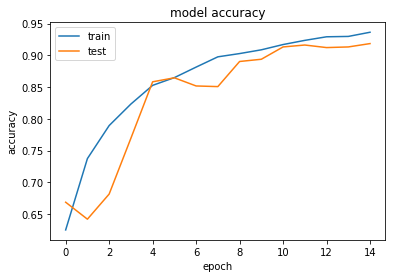

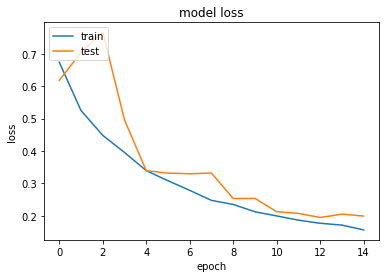

In [99]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model as JSON

In [100]:
model_json = model.to_json()
with open("designed_model_1.json", "w") as json_file:
    json_file.write(model_json)

# Update lr and training: 2

In [108]:
from keras import backend as K
K.set_value(model.optimizer.lr, 0.001)

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_steps,
    callbacks=callbacks
)


Epoch 1/15
327/328 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9409
Epoch 00001: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 159s 483ms/step - loss: 0.1487 - acc: 0.9410 - val_loss: 0.1673 - val_acc: 0.9279
Epoch 2/15
327/328 [============================>.] - ETA: 0s - loss: 0.1503 - acc: 0.9396
Epoch 00002: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 159s 485ms/step - loss: 0.1504 - acc: 0.9395 - val_loss: 0.3192 - val_acc: 0.8735
Epoch 3/15
327/328 [============================>.] - ETA: 0s - loss: 0.1450 - acc: 0.9404
Epoch 00003: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 167s 509ms/step - loss: 0.1452 - acc: 0.9403 - val_loss: 0.1834 - val_acc: 0.9234
Epoch 4/15
327/328 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9440
Epoch 00004: saving model to Model_Weights/desig

# Plot loss and Accuracy

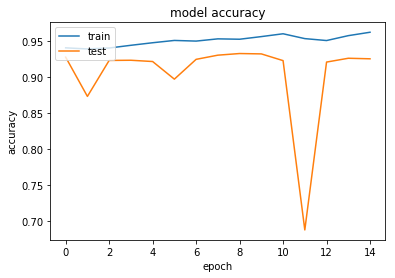

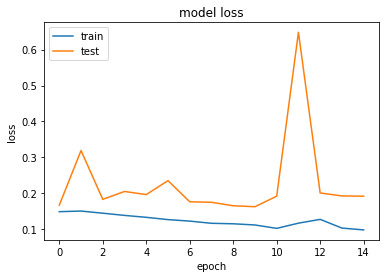

In [109]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Update lr and training: 3

In [110]:
from keras import backend as K
K.set_value(model.optimizer.lr, 0.0005)

epochs = 30

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_steps,
    callbacks=callbacks
)

Epoch 1/30
327/328 [============================>.] - ETA: 0s - loss: 0.0856 - acc: 0.9666
Epoch 00001: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 158s 481ms/step - loss: 0.0855 - acc: 0.9667 - val_loss: 0.1560 - val_acc: 0.9403
Epoch 2/30
327/328 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9649
Epoch 00002: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 163s 496ms/step - loss: 0.0906 - acc: 0.9649 - val_loss: 0.1831 - val_acc: 0.9267
Epoch 3/30
327/328 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9608
Epoch 00003: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 157s 479ms/step - loss: 0.1006 - acc: 0.9608 - val_loss: 0.1377 - val_acc: 0.9443
Epoch 4/30
327/328 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9701
Epoch 00004: saving model to Model_Weights/desig

328/328 [==============================] - 153s 465ms/step - loss: 0.0522 - acc: 0.9810 - val_loss: 0.1340 - val_acc: 0.9531
Epoch 30/30
327/328 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9853
Epoch 00030: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 152s 463ms/step - loss: 0.0387 - acc: 0.9854 - val_loss: 0.1576 - val_acc: 0.9521


# Plot loss and Accuracy

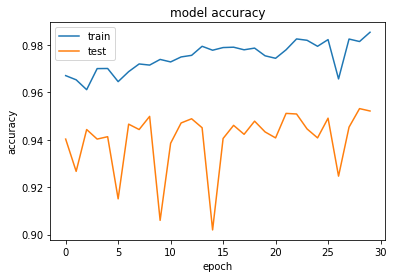

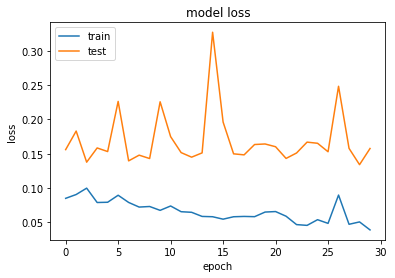

In [111]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Update lr and training: 4

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.lr, 0.0002)

epochs = 30

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_stepas,
    callbacks=callbacks
)

Epoch 1/30
327/328 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9875
Epoch 00001: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 162s 493ms/step - loss: 0.0334 - acc: 0.9875 - val_loss: 0.1434 - val_acc: 0.9509
Epoch 2/30
327/328 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9846
Epoch 00002: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 153s 466ms/step - loss: 0.0426 - acc: 0.9846 - val_loss: 0.1489 - val_acc: 0.9531
Epoch 3/30
327/328 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9828
Epoch 00003: saving model to Model_Weights/designed_model_1_weights.h5
328/328 [==============================] - 155s 474ms/step - loss: 0.0435 - acc: 0.9829 - val_loss: 0.1725 - val_acc: 0.9451
Epoch 4/30
327/328 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9854
Epoch 00004: saving model to Model_Weights/desig